In [1]:
import IGA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def create_knot_vector(num_knots, p, delta, midpoint_interp=True):

    h = 1.0 / num_knots

    if delta > h:
        num_boundary_elements = np.ceil(delta / h)
    else:
        num_boundary_elements = 1

    x1 = np.linspace(-delta, 0, num=num_boundary_elements, endpoint=False)
    x2 = np.linspace(1, 1 + delta, num=num_boundary_elements + 1)
    omega_p1 = np.r_[ -delta, (np.ones((x1.shape[0],p)) * x1[:,None]).ravel()]
    omega_p2 = np.r_[(np.ones((x2.shape[0],p)) * x2[:,None]).ravel(), 1 + delta]
    
    
    omega1a = np.zeros(p-1)
    omega1b = np.linspace(0, 0.5, num=np.int(np.ceil(num_knots / 2)), endpoint=False)
    if midpoint_interp:
        omega1c = np.ones(p+1) * 0.5
        omega2a = np.linspace(0.5, 1.0, num=np.int(np.ceil(num_knots / 2)), endpoint=False)
    else:
        omega1c = np.ones(1) * 0.5
        omega2a = np.linspace(0.5, 1.0, num=np.int(np.ceil(num_knots / 2)), endpoint=False)
    
    return (np.r_[omega_p1, omega1a, omega1b, omega1c, omega2a[1:], omega_p2], num_boundary_elements)

def run_case_1(num_knots, order, delta, norm, quad_degree=10):

    knot_vector, num_boundary_elements = create_knot_vector(num_knots, order, delta, midpoint_interp=False)

    iga = IGA.PD1D(knot_vector, order, delta)
    iga.degree = quad_degree
    
    u = lambda x: x * (1 - x)
    b = lambda x: np.ones(x.shape[0])

    iga.compute_solutions(u, b, num_boundary_elements)
    
    return iga.compute_error(norm=norm)


def run_case_2(num_knots, order, delta, norm, quad_degree=10):

    knot_vector, num_boundary_elements = create_knot_vector(num_knots, order, delta)

    iga = IGA.PD1D(knot_vector, order, delta)
    iga.degree = quad_degree
    
    def u(x):
        return np.where(x < 0.5, x, x * x)

    def b(x):
        cond1a = 0 <= x 
        cond1b = x < 0.5 - delta
        cond2a = 0.5 - delta <= x
        cond2b = x < 0.5
        cond3a = 0.5 < x
        cond3b = x < 0.5 + delta
        cond4a = 0.5 + delta <= x
        cond4b = x <= 1.0
        
        I1val = 0.0
        I2val = -1.0 / delta ** 2. * (0.5 * delta ** 2. - delta + 3. / 8. +
                    (2. * delta - 3. / 2. - np.log(delta)) * x + (3. / 2. + np.log(delta)) * x ** 2.
                    - (x ** 2. - x) * np.log(1. / 2. - x))
                                        
        I3val = -1.0 / delta ** 2. * (0.5 * delta ** 2. - delta - 3. / 8. +
                    (2. * delta + 3. / 2. + np.log(delta)) * x - (3. / 2. + np.log(delta)) * x ** 2.
                    + (x ** 2. - x) * np.log(x - 1. / 2.))
        I4val = -1.0
        
        temp1 = np.where(cond1a & cond1b, I1val, x)
        temp2 = np.where(cond2a & cond2b, I2val, temp1)
        temp3 = np.where(cond3a & cond3b, I3val, temp2)
        return np.where(cond4a & cond4b, I4val, temp3)

    iga.compute_solutions(u, b, num_boundary_elements)
    
    return iga.compute_error(norm=norm)

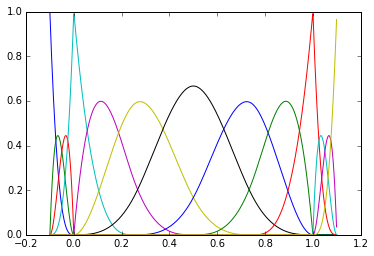

In [2]:
num_knots = 4 
order=3 
delta=0.1
knot_vector, nbe = create_knot_vector(num_knots, order, delta, midpoint_interp=False)
iga = IGA.PD1D(knot_vector, order, delta)
iga.N.plot()

In [4]:
dofs1 = np.array([4,50,100,200]);
errs1 = [ run_case_1(num_knots, order=1, delta=0.1, norm=2, quad_degree=20) for num_knots in dofs1 ];

[[ 0.          0.          0.          0.          0.          0.          0.        ]
 [-2.29028326  3.11717354 -0.73766725 -0.08922303  0.          0.          0.        ]
 [-0.22305757 -1.51994602  3.48600716 -1.65378056 -0.08922303  0.          0.        ]
 [ 0.         -0.08922303 -1.65378056  3.48600716 -1.65378056 -0.08922303
   0.        ]
 [ 0.          0.         -0.08922303 -1.65378056  3.48600716 -1.51994602
  -0.22305757]
 [ 0.          0.          0.         -0.08922303 -0.73766725  3.11717354
  -2.29028326]
 [ 0.          0.          0.          0.          0.          0.          0.        ]]
[[ 3.11717354 -0.73766725 -0.08922303  0.          0.        ]
 [-1.51994602  3.48600716 -1.65378056 -0.08922303  0.        ]
 [-0.08922303 -1.65378056  3.48600716 -1.65378056 -0.08922303]
 [ 0.         -0.08922303 -1.65378056  3.48600716 -1.51994602]
 [ 0.          0.         -0.08922303 -0.73766725  3.11717354]]


NameError: name 'num_boundary_elements' is not defined

In [1]:
#Fit a straight line
#coefs1 = np.polyfit(np.log10(1.0 / dofs1), np.log10(errs1), 1)
#y1 = 10 ** (coefs1[0] * np.log10(1.0 / dofs1) + coefs1[1])
#Plot
plt.loglog(dofs1, errs1, 'b-')
plt.loglog(dofs1, errs1, 'b^')
plt.xlabel("$\log_{10} N$")
plt.ylabel("$\log_{10} \Vert u - u^h \Vert_{L_2}$");
plt.xlim([1, 1000])
plt.grid()

NameError: name 'plt' is not defined

In [37]:
dofs2 = np.array([10,50,100,200]);
errs2 = [ run_case_2(num_knots, order=1, delta=0.5, norm=2, quad_degree=12) for num_knots in dofs2 ];

-c:39: RuntimeWarning: divide by zero encountered in log
-c:39: RuntimeWarning: invalid value encountered in log
-c:43: RuntimeWarning: divide by zero encountered in log
-c:43: RuntimeWarning: invalid value encountered in log


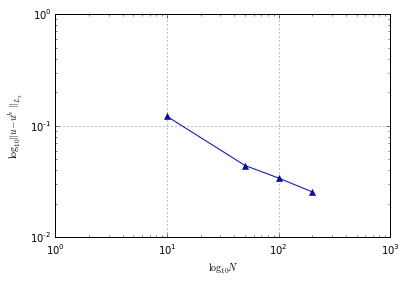

In [38]:
#Fit a straight line
plt.loglog(dofs2, errs2, 'b-')
plt.loglog(dofs2, errs2, 'b^')
plt.xlabel("$\log_{10} N$")
plt.ylabel("$\log_{10} \Vert u - u^h \Vert_{L_2}$");
plt.xlim([1, 1000])
plt.grid()

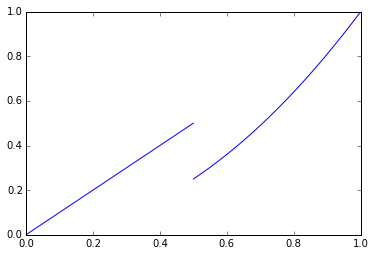

In [40]:
def u(x):
    return np.where(x < 0.5, x, x * x)

def b(x):
        delta = 0.3
        cond1a = 0 <= x 
        cond1b = x < 0.5 - delta
        cond2a = 0.5 - delta <= x
        cond2b = x < 0.5
        cond3a = 0.5 < x
        cond3b = x < 0.5 + delta
        cond4a = 0.5 + delta <= x
        cond4b = x <= 1.0
        
        I1val = 0.0
        I2val = -1.0 / delta ** 2. * (0.5 * delta ** 2. - delta + 3. / 8. +
                    (2. * delta - 3. / 2. - np.log(delta)) * x + (3. / 2. + np.log(delta)) * x ** 2.
                    - (x ** 2. - x) * np.log(1. / 2. - x))
                                        
        I3val = -1.0 / delta ** 2. * (0.5 * delta ** 2. - delta - 3. / 8. +
                    (2. * delta + 3. / 2. + np.log(delta)) * x - (3. / 2. + np.log(delta)) * x ** 2.
                    + (x ** 2. - x) * np.log(x - 1. / 2.))
        I4val = -1.0
        
        temp1 = np.where(cond1a & cond1b, I1val, x)
        temp2 = np.where(cond2a & cond2b, I2val, temp1)
        temp3 = np.where(cond3a & cond3b, I3val, temp2)
        return np.where(cond4a & cond4b, I4val, temp3)
    
x1 = np.linspace(0,0.5,num=5000,endpoint=False)
x2 = np.linspace(0.5,1.0,num=5000)
plt.plot(x1,u(x1), 'b-', x2[1:],u(x2[1:]),'b-');

-c:22: RuntimeWarning: invalid value encountered in log
-c:18: RuntimeWarning: invalid value encountered in log


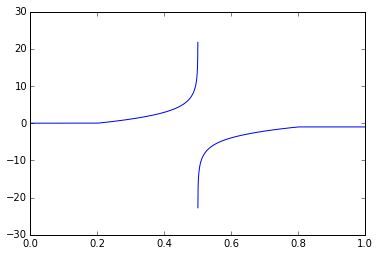

In [41]:
plt.plot(x1,b(x1), 'b-', x2[1:],b(x2[1:]),'b-');